In [ ]:
# install pyannote.audio from source
!pip install -U pip
!pip install git+https://github.com/hadware/pyannote-audio.git@feat-vtc-preprocessors#egg=pyannote.audio
!pip install -U git+https://github.com/pyannote/pyannote-metrics.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hadware/pyannote-audio.git (to revision feat-vtc-preprocessors) to /tmp/pip-install-hhos0yp7/pyannote-audio_990acf8561c84bffbdd6b645ce6a2c33
  Running command git clone --filter=blob:none --quiet https://github.com/hadware/pyannote-audio.git /tmp/pip-install-hhos0yp7/pyannote-audio_990acf8561c84bffbdd6b645ce6a2c33
  Running command git checkout -b feat-vtc-preprocessors --track origin/feat-vtc-preprocessors
  Switched to a new branch 'feat-vtc-preprocessors'
  Branch 'feat-vtc-preprocessors' set up to track remote branch 'feat-vtc-preprocessors' from 'origin'.
  Resolved https://github.com/hadware/pyannote-audio.git to commit 345a2624652648669374c1a29890ef5ce019003d
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... d

In [ ]:
# install & download AMI mini corpus
%cd /content/
!git clone https://github.com/hadware/AMI-diarization-setup
%cd /content/AMI-diarization-setup/pyannote/
!bash download_ami_mini.sh

Cloning into 'AMI-diarization-setup'...
remote: Enumerating objects: 945, done.
remote: Counting objects: 100% (945/945), done.
remote: Compressing objects: 100% (409/409), done.
remote: Total 945 (delta 370), reused 932 (delta 361), pack-reused 0
Receiving objects: 100% (945/945), 1.66 MiB | 1.48 MiB/s, done.
Resolving deltas: 100% (370/370), done.
/content/AMI-diarization-setup/pyannote
--2022-06-20 14:00:27--  http://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav
Resolving groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)... 129.215.202.26
Connecting to groups.inf.ed.ac.uk (groups.inf.ed.ac.uk)|129.215.202.26|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav [following]
--2022-06-20 14:00:28--  https://groups.inf.ed.ac.uk/ami/AMICorpusMirror/amicorpus/ES2002a/audio/ES2002a.Mix-Headset.wav
Connecting to groups.inf.ed.

## Data Preparation

This dataset contains annotated segments of audio that are recordings of some conversations. Each speaker has a unique ID and can be either a male or a female. We'll need to implement an annotation preprocessor for this,  that remaps speaker labels to either `MALE` or `FEMALE` based on AMI labels.

In [ ]:
import os
from pyannote.database.protocol.protocol import Preprocessor
from pyannote.database import ProtocolFile
from typing import Dict, Any, List
from pyannote.audio.utils.preprocessors import DeriveMetaLabels
from pyannote.database import get_protocol, FileFinder
from pyannote.database.custom import add_custom_protocols

os.environ["PYANNOTE_DATABASE_CONFIG"] = "/content/AMI-diarization-setup/pyannote/database.yml"

# for some reason, pyannote.db won't load the database properly if this isn't invoked
add_custom_protocols() 

class AMILabelMapper(Preprocessor):
  """Remapping the AMI labels to MALE or FEMALE based on speaker ID"""

  def __call__(self, current_file: ProtocolFile):
    labels = current_file["annotation"].labels()
    mapping = {lbl : "MALE" if lbl.startswith("M") else "FEMALE" 
               for lbl in labels}
    return current_file["annotation"].rename_labels(mapping=mapping)


ami = get_protocol("AMI.SpeakerDiarization.mini", 
                   {"audio": FileFinder(),
                    "annotation": AMILabelMapper()})

`pyannote.database` *protocols* usually define 
* a training set: `for training_file in protocol.train(): ...`, 
* a validation set: `for validation_file in protocol.development(): ...` 
* an evaluation set `for evaluation_file in protocol.test(): ...`

Let's vizualize what a training file's annotation, and then listen to it

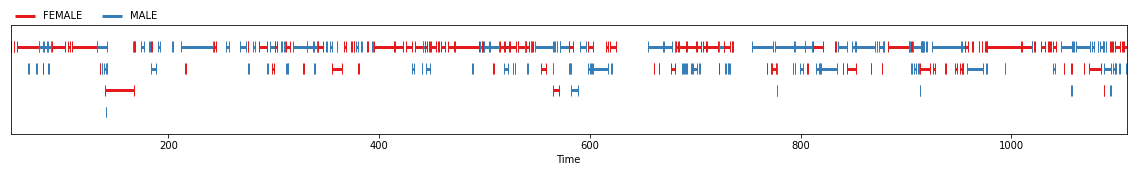

In [ ]:
first_training_file = next(ami.train())
first_training_file["annotation"]

In [ ]:
from pyannote.audio.utils.preview import listen

listen(first_training_file)

# TRAINING

We initialize a multilabeling *task* that describes how the model will be trained:

* `ami` indicates that we will use files available in `ami.train()`.
* `duration=2.` and `batch_size=128` indicates that the model will ingest batches of 128 two seconds long audio chunks.

In [ ]:
from pyannote.audio import tasks

vtc_task = tasks.MultilabelDetection(ami, duration=2., batch_size=128)

Protocol AMI.SpeakerDiarization.mini does not precompute the output of torchaudio.info(): adding a 'torchaudio.info' preprocessor for you to speed up dataloaders. See pyannote.database documentation on how to do that yourself.


We initialize one *model* with the `PyanNet` architecture used [in that paper](https://arxiv.org/abs/2104.04045).  
In particular, we increase the default stride of the initial `sincnet` feature extraction layer to `10`.

The model is also provided with the task (`task=vad`) for which it is being trained:

In [ ]:
from pyannote.audio.models.segmentation import PyanNet

model = PyanNet(task=vtc_task)

Now that everything is ready, let's train with `pytorch-ligthning`!


In [ ]:
import pytorch_lightning as pl

trainer = pl.Trainer(gpus=1, max_epochs=20)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/AMI-diarization-setup/pyannote/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type             | Params | In sizes        | Out sizes                                        
-----------------------------------------------------------------------------------------------------------------------------
0 | sincnet           | SincNet          | 42.6 K | [128, 1, 32000] | [128, 60, 115]                                   
1 | lstm              | LSTM             | 589 K  | [128, 115, 60]  | [[128, 115, 256], [[4, 128, 128], [4, 128, 128]]]
2 | linear            | ModuleList       | 49.4 K | ?               | ?                                                
3 | classifier        | Linear           | 258    | [128, 115, 128] | [128, 115, 2]                                    
4 | acti

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

For the purpose of this tutorial, the model is trained on only 20 epochs. One can obviously expect better performance by training longer and on more data.

See [`pytorch-lightning`](https://www.pytorchlightning.ai/) documentation to learn more about the [`Trainer` API](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html), in particular.

# Inference

Once trained, the model can be applied to a test file:

In [ ]:
test_file = next(ami.test())

Because the model was trained on 2s audio chunks and that test files are likely to be much longer than that, we wrap the `model` with an `Inference` instance: it will take care of sliding a 2s window over the whole file and aggregate the output of the model.

In [ ]:
from pyannote.audio import Inference

inference = Inference(model)
labels_probability = inference(test_file)

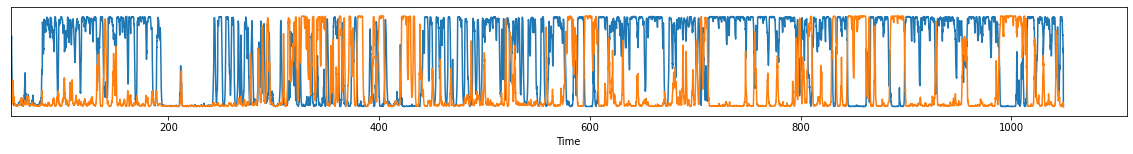

In [ ]:
labels_probability

A perfect voice type classification output should look like that:

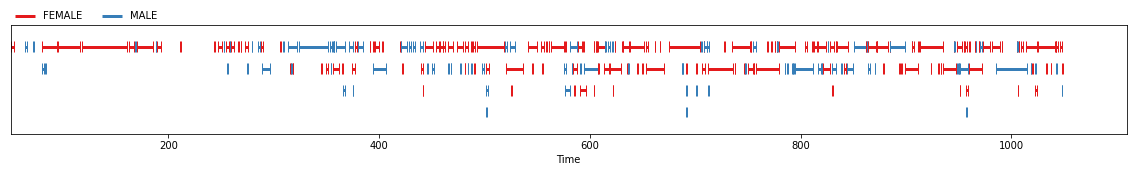

In [ ]:
expected_output = test_file["annotation"]
expected_output

# Pipeline


Almost there! To obtain the final speech regions, we need to apply a detection threshold.  
For that, we rely on the voice activity detection pipeline whose hyper-parameters are set manually:
- `onset=0.1`: mark region as `active` when probability goes above 0.1
- `offset=0.3`: switch back to `inactive` when probability goes below 0.3
- `min_duration_on=0.0`: remove `active` regions shorter than that many seconds
- `min_duration_off=0.0`: fill `inactive` regions shorter than that many seconds


More details about those hyper-parameters are provided in Figure 2 of [that paper](https://arxiv.org/abs/2104.04045).

In [ ]:
from pyannote.audio import pipelines

pipeline = pipelines.MultilabelDetection(segmentation=model)
initial_params = {"thresholds" : {class_label: {"onset": 0.1, 
                                                "offset": 0.3,
                                                "min_duration_on": 0.0, 
                                                "min_duration_off": 0.0}
                  for class_label in pipeline.classes()}}
pipeline.instantiate(initial_params)


Here we go:

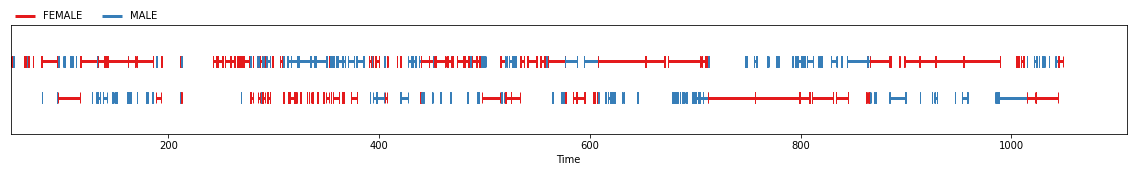

In [ ]:
pipeline(test_file)

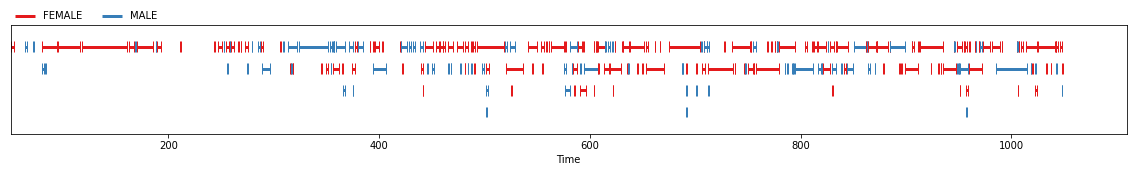

In [ ]:
expected_output

That doesn't look too bad... Let's perform a proper evaluation by computing the [identification error rate](https://pyannote.github.io/pyannote-metrics/reference.html#identification) over the whole AMI test set:

In [ ]:


from pyannote.metrics.identification import IdentificationErrorRate

metric = IdentificationErrorRate()

for file in ami.test():
    # apply the voice activity detection pipeline
    speech = pipeline(file)

    # evaluate its output
    _ = metric(
        file['annotation'],  # this is the reference annotation
        speech,  # this is the hypothesized annotation
        uem=file['annotated'])  # this is the part of the file that should be evaluated

# aggregate the performance over the whole test set
identification_error_rate = abs(metric)
print(f'Identification error rate = {identification_error_rate * 100:.1f}%')


Identification error rate = 31.2%


# Optimizing pipeline hyper-parameters

This definitely can be improved by tweaking the hyper parameters we chose manually. We can try to optimize `onset` and `offset` on the development (a.k.a. validation) set to get better performance (and freeze the other two hyper-parameters).

In [ ]:
for label in pipeline.classes():
    pipeline.freeze({ 'thresholds' : {label: {'min_duration_on': 0.0, 'min_duration_off': 0.0}}})

In [ ]:
from pyannote.pipeline import Optimizer

optimizer = Optimizer(pipeline)
optimizer.tune(list(ami.development()),
               warm_start=initial_params,
               n_iterations=10,
               show_progress=True)

optimized_params = optimizer.best_params


Current trial: 100%|██████████| 1/1 [00:24<00:00, 24.14s/it]
                                                            
Current trial: 100%|██████████| 1/1 [01:16<00:00, 76.74s/it]
                                                            
Current trial: 100%|██████████| 1/1 [04:42<00:00, 282.36s/it]
                                                             
Current trial: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]
                                                            
Current trial: 100%|██████████| 1/1 [00:09<00:00,  9.83s/it]
                                                            
Current trial: 100%|██████████| 1/1 [00:08<00:00,  8.94s/it]
                                                            
Current trial: 100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
                                                            
Current trial: 100%|██████████| 1/1 [01:58<00:00, 118.54s/it]
                                                             
Current trial: 100%

There you go: better hyper-parameters that lead to better results!

In [ ]:
optimized_params

{'thresholds': {'FEMALE': {'min_duration_off': 0.0,
   'min_duration_on': 0.0,
   'offset': 0.5618766052911011,
   'onset': 0.3185461184424274},
  'MALE': {'min_duration_off': 0.0,
   'min_duration_on': 0.0,
   'offset': 0.6102018404831496,
   'onset': 0.5674177000337595}}}

Let's evaluate the voice activity detection pipeline with this new set of hyper-parameters:

In [ ]:
optimized_pipeline = pipeline.instantiate(optimized_params)

metric = IdentificationErrorRate()

for file in ami.test():
    speech = optimized_pipeline(file)
    _ = metric(file['annotation'], speech, uem=file['annotated'])

identification_error_rate = abs(metric)
print(f'Identification error rate = {identification_error_rate * 100:.1f}%')



Identification error rate = 27.2%


A gain of 4% of IER! 🎊🎊🎊